__Выбор локации для скважины__

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:

 - В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
 - Строят модель для предсказания объёма запасов в новых скважинах;
 - Выбирают скважины с самыми высокими оценками значений;
 - Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

## Загрузка и обработка данных

### Цель и план исследования

__Инструкция по выполнению проекта:__

   - Загрузите и подготовьте данные. Поясните порядок действий.
   - Обучите и проверьте модель для каждого региона:
       - 2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
       - 2.2. Обучите модель и сделайте предсказания на валидационной выборке.
       - 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
       - 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
       - 2.5. Проанализируйте результаты.
   - Подготовьтесь к расчёту прибыли:
       - 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.
       - 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.
       - 3.3. Напишите выводы по этапу подготовки расчёта прибыли.
   - Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
       - 4.1. Выберите скважины с максимальными значениями предсказаний.
       - 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
       - 4.3. Рассчитайте прибыль для полученного объёма сырья.
    - Посчитайте риски и прибыль для каждого региона:
       - 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
       - 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
       - 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

__Описание данных:__
   
   - id — уникальный идентификатор скважины;
   - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
   - product — объём запасов в скважине (тыс. баррелей).

__Условия задачи:__

   - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
   - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
   - Бюджет на разработку скважин в регионе — 10 млрд рублей.
   - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
   - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Загрузка приложений

In [1]:
import os

import pandas as pd
import numpy as np
from scipy import stats as st

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython import get_ipython
ipython = get_ipython()


# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

#ml
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns 

import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


import warnings 
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None


In [2]:
!pip install imbalanced-learn
!pip install phik

In [3]:
#немного опций для удобства

pd.options.display.max_rows = 7
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

large = 16; med = 12; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (12, 8),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

sns.set_palette('deep') 
sns.set_style("whitegrid")

from matplotlib import rcParams, rcParamsDefault

rcParams['figure.figsize'] = 12,12
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
factor = 10
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi*factor

### Загрузка  файла

In [5]:
# не получилось сделать в цикле, делаем вручную

pth1='/home/alexandra/data_science/geo_data_0.csv'
pth2='/datasets/geo_data_0.csv'
pth3='https://code.s3.yandex.net/datasets/geo_data_0.csv'

try:
  
    if os.path.exists(pth1):
        df_0 = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        df_0 = pd.read_csv(pth2, delimiter='\,')
    # elif os.path.exists(pth3):
    #     df = pd.read_csv(pth3, delimiter='\,')
    else:
        df_0 = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')
    

pth1='/home/alexandra/data_science/geo_data_1.csv'
pth2='/datasets/geo_data_1.csv'
pth3='https://code.s3.yandex.net/datasets/geo_data_1.csv'

try:
  
    if os.path.exists(pth1):
        df_1 = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        df_1 = pd.read_csv(pth2, delimiter='\,')
    # elif os.path.exists(pth3):
    #     df = pd.read_csv(pth3, delimiter='\,')
    else:
        df_1 = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')

pth1='/home/alexandra/data_science/geo_data_2.csv'
pth2='/datasets/geo_data_2.csv'
pth3='https://code.s3.yandex.net/datasets/geo_data_2.csv'

try:
  
    if os.path.exists(pth1):
        df_2 = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        df_2 = pd.read_csv(pth2, delimiter='\,')
    # elif os.path.exists(pth3):
    #     df = pd.read_csv(pth3, delimiter='\,')
    else:
        df_2 = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')

df=[df_0, df_1, df_2]

Загрузка файла прошла успешно
Загрузка файла прошла успешно
Загрузка файла прошла успешно


In [6]:
for i in range(3):
    display(df[i])
    

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
...,...,...,...,...,...
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
...,...,...,...,...,...
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
...,...,...,...,...,...
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


In [7]:
for i in range(3):
    print('Регион', i)
    df[i].info()
    print( )

Регион 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Регион 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Регион 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 colu

Пропусков нет, данные полные.

### Обработка данных

In [8]:
# удалим столбцы с ID
for i in range(3):
    df[i].drop('id', axis=1, inplace=True)

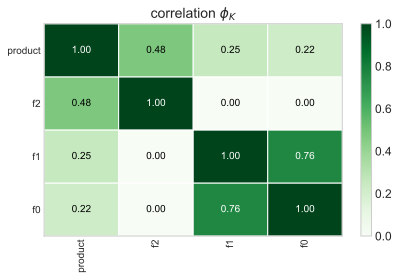

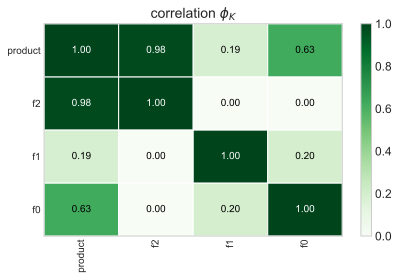

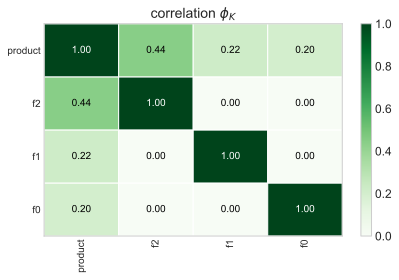

In [9]:
# проверяем данные на коллинеарность
from phik.report import correlation_report, plot_correlation_matrix

for i in range(3):
    interval_cols = df[i].select_dtypes('number').columns.tolist()
    phik_overview = df[i].phik_matrix(interval_cols=interval_cols)
    plot_correlation_matrix(phik_overview.values, 
                            x_labels=phik_overview.columns, 
                            y_labels=phik_overview.index, 
                            vmin=0, vmax=1, color_map="Greens", 
                            title=r"correlation $\phi_K$", 
                            fontsize_factor=1, 
                            figsize=(6, 4))
    plt.tight_layout()

array([[<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f1'}>],
       [<AxesSubplot: title={'center': 'f2'}>,
        <AxesSubplot: title={'center': 'product'}>]], dtype=object)

array([[<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f1'}>],
       [<AxesSubplot: title={'center': 'f2'}>,
        <AxesSubplot: title={'center': 'product'}>]], dtype=object)

array([[<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f1'}>],
       [<AxesSubplot: title={'center': 'f2'}>,
        <AxesSubplot: title={'center': 'product'}>]], dtype=object)

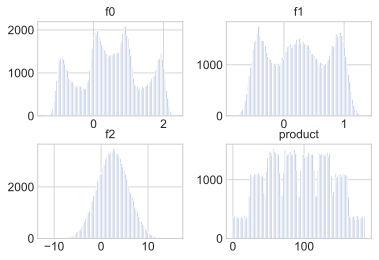

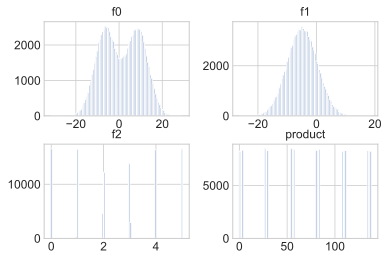

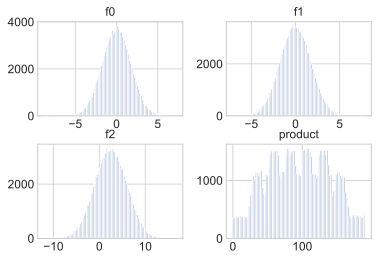

In [10]:
for i in range(3):
    df[i].hist(bins=100)

Понятно, что данные несколько сфабрикованны, но есть сильные корелляции между некоторыми столбцами. 
При работе с реальными данными пришлось бы разбирать в причинах такой сильной корреляции.

Гистограммы также показывают странное распределение. Ну ОК, будем считать эти данные условно нормальными.

## Обучение и проверка модели для каждого региона

### Разбивка данных на обучающую и валидационную выборки


In [11]:
target=[]
features = []
for i in range(3):
    target.append(df[i]['product'])
    features.append(df[i].drop('product', axis=1))

features_train=[]
features_valid=[]
target_train=[]
target_valid=[]
for i in range(3):
    features_t, features_v, target_t, target_v = train_test_split(features[i], target[i], test_size=0.25, random_state=12345)
    features_train.append(features_t)
    features_valid.append(features_v)
    target_train.append(target_t)
    target_valid.append(target_v)

    

In [12]:
for i in range(3):
    features_train[i].shape
    features_valid[i].shape

(75000, 3)

(25000, 3)

(75000, 3)

(25000, 3)

(75000, 3)

(25000, 3)

<AxesSubplot: >

<AxesSubplot: >

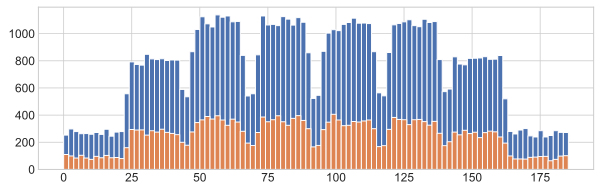

In [13]:
target_train[0].hist(bins=100, figsize=(10, 3))
target_valid[0].hist(bins=100)

Разбивка данных прошла успешно. Можно переходить к обучению модели.

### Обучение модели

In [14]:
prediction=[]
for i in range(3):
    model=LinearRegression().fit(features_train[i],target_train[i])
    prediction.append(model.predict(features_valid[i]))


In [15]:
df_t_p=[]
for i in range(3):
    prediction_s = pd.Series(prediction[i], name='prediction')
    target_valid_s = pd.Series(target_valid[i].reset_index(drop=True), index=prediction_s.index)
    df_tmp=pd.concat([prediction_s, target_valid_s], axis=1)
    df_t_p.append(df_tmp)
   
    

### Средний запас предсказанного сырья и RMSE модели

In [16]:
for i in range(3):
    print('Регион', i)
    print('Средний запас сырья по региону',  df_t_p[i]['product'].mean())
    print('Средний запас предсказанного сырья по региону', df_t_p[i]['prediction'].mean())
    mse=mean_squared_error(df_t_p[i]['product'],df_t_p[i]['prediction'])
    rmse=round((mse)**0.5,3)
    print('RMSE по региону', rmse)
    print()

Регион 0
Средний запас сырья по региону 92.07859674082927
Средний запас предсказанного сырья по региону 92.59256778438035
RMSE по региону 37.579

Регион 1
Средний запас сырья по региону 68.72313602435997
Средний запас предсказанного сырья по региону 68.728546895446
RMSE по региону 0.893

Регион 2
Средний запас сырья по региону 94.88423280885438
Средний запас предсказанного сырья по региону 94.96504596800489
RMSE по региону 40.03



### Анализ результатов

По расчитанным данным видно, что очень сильно предсказания зависят от структуры самих данных. 
По региону 1 такая низкая ошибка предсказуема, так как сама выборка данных предсказуема плюс была линейная зависимость между признаками.
По остальным регионам ошибка достаточно большая.

## Расчет прибыли. Подготовка

In [17]:
#Все ключевые значения для расчётов сохраняем в отдельных переменных.
budjet=10000000000 # Бюджет на разработку скважин в регионе 
income = 450000 #Доход с 1000 баррелей
n_wells=200 #

### Расчет достаточного объёма сырья для безубыточной разработки новой скважины

In [18]:
well_price=budjet/n_wells #стоимость разработки одной скважины
oil_vol=round(well_price/income, 2) #достаточный объём сырья
print('Бюджет на разработку одной скважины:', well_price)
print('Достаточный объём сырья для безубыточной разработки новой скважины', oil_vol, 'тыс.баррелей')

Бюджет на разработку одной скважины: 50000000.0
Достаточный объём сырья для безубыточной разработки новой скважины 111.11 тыс.баррелей


### Сравнение полученного объёма сырья со средним запасом в каждом регионе.

In [19]:
for i in range(3):
    print('Регион', i)
    if df_t_p[i]['product'].mean() > oil_vol:
        print('Объем сырья достаточный для безубыточной разработки новой скважины')
    else:
        print('Объем сырья Недостаточный для безубыточной разработки новой скважины')
    print()


Регион 0
Объем сырья Недостаточный для безубыточной разработки новой скважины

Регион 1
Объем сырья Недостаточный для безубыточной разработки новой скважины

Регион 2
Объем сырья Недостаточный для безубыточной разработки новой скважины



Выводы: На данном этапе разработка новых скважин в любом регионе представляется убыточной

## Расчёт прибыли по выбранным скважинам и предсказаниям модели

In [20]:
def revenue(i):
    df_t_p_sorted = df_t_p[i].sort_values(by='prediction', ascending=False).head(200)
    return round(df_t_p_sorted['product'].sum() * 450000 - 10000000000)

In [21]:
for i in range(3):
    print('Регион', i)
    print("Прибыль по Топ 200:", revenue(i)/1000000, 'млн.руб.') 
    print()

Регион 0
Прибыль по Топ 200: 3320.826043 млн.руб.

Регион 1
Прибыль по Топ 200: 2415.086697 млн.руб.

Регион 2
Прибыль по Топ 200: 2710.349964 млн.руб.



## Риски и прибыль для каждого региона


### Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [22]:
from scipy import stats



state = np.random.RandomState(12345)
revenue_bs_all=[]
for i in range(3):
    revenue_bs=[]
    for index in range(1000):
        prediction_subsample=df_t_p[i]['prediction'].sample(n=500, replace=True, random_state=state)
        target_subsample=df_t_p[i]['product'][prediction_subsample.index]
        df_subsample=pd.concat([prediction_subsample, target_subsample], axis=1).sort_values(by='prediction', ascending=False).head(200)
        revenue_bs.append(df_subsample['product'].sum() * 450000 - 10000000000)
    revenue_bs=pd.Series(revenue_bs)
    revenue_bs_all.append(revenue_bs) 
    revenue_bs_mean=revenue_bs.mean()
    upper=revenue_bs.quantile(0.975)
    lower =revenue_bs.quantile(q=0.025)
    confidence_interval = st.t.interval(0.95, len(revenue_bs)-1, revenue_bs.mean(), revenue_bs.sem()) 
    risk=stats.percentileofscore(revenue_bs, 0)
    print('Регион', i)
    print("Средняя прибыль по Bootstrap:", revenue_bs_mean/1000000, 'млн.руб.') 
    print("95%-ый доверительный интервал:", lower/1000000, upper/1000000, 'млн.руб.')
    print("Вероятность отрицательной прибыли", risk, '%')
    print()
    print()
           



Регион 0
Средняя прибыль по Bootstrap: 396.16498480237107 млн.руб.
95%-ый доверительный интервал: -111.21554589049525 909.7669415534226 млн.руб.
Вероятность отрицательной прибыли 6.9 %


Регион 1
Средняя прибыль по Bootstrap: 461.1558172772397 млн.руб.
95%-ый доверительный интервал: 78.05081075174171 862.9520602637234 млн.руб.
Вероятность отрицательной прибыли 0.7 %


Регион 2
Средняя прибыль по Bootstrap: 392.9504751706045 млн.руб.
95%-ый доверительный интервал: -112.22762537857565 934.5629145511635 млн.руб.
Вероятность отрицательной прибыли 6.5 %




### Выводы: предложите регион для разработки скважин и обоснуйте выбор.

Наиболее перспективным для разработки скважин мне представляется регион 1.
В нем наибольшая средняя прибыль, наименьшая вероятность отрицательной прибыли.